In [1]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from IPython.display import Image as display_image
from okiya import draw_tiles, bin_interpretation, split_list_n, unzip, turn_number

In [2]:
player = 0 # Red player
#player = 1 # Black player

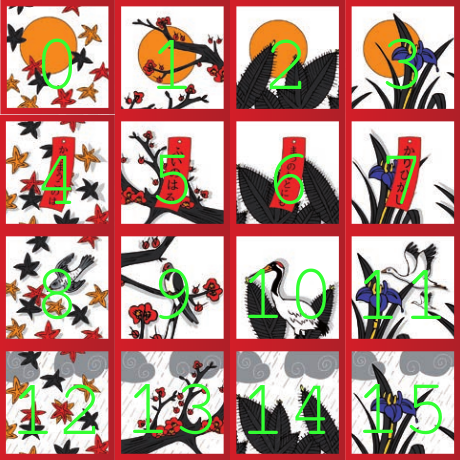

In [3]:
tiles = np.array([i for i in range(0,16)]).reshape([4,4])
img_path = draw_tiles(tiles, draw_numbers = True, hi_res = False)
display_image(img_path)

In [4]:
init_tiles = np.array([
    [8,1,3,15],
    [9,10,12,2],
    [14,6,5,0],
    [11,4,7,13]
])
img_path = draw_tiles(init_tiles, draw_numbers = False, hi_res = False)
display_image(img_path)

# prepare for gpu
init_tiles_array = []
for row in init_tiles:
    init_tiles_array = np.concatenate((init_tiles_array, row), axis=0)
init_tiles_gpu = gpuarray.to_gpu(init_tiles_array.astype(np.int32))

In [5]:
len(bin_interpretation(2147483647))

31

В карте 1080-ti, MAX_GRID_DIM_X = 2 147 483 647, что позволяет обрабатывать за один такт 2 млрд комбинаций.  
Упаковать их можно в 31 бите.  
План действий:  
1. Вычисляем общее количество возможных победных комбинаций на последнем ходе: 2145. Это 12 бит.  
2. Задаем изначальное расположение тайлов на поле  
3. Все комбинации маски поля это 16 единиц, или 16 бит.  
4. Для каждого хода, передаем в ядро:  
- Игрок, победа которого нас интересует: 0 или 1  
- Текущий ход: от 0 до 15  
- Расположение тайлов игры и фишек игроков: 16 значений от 0 до 17. 16 и 17 значения - фишки игроков.
- Входной вектор смещений побед: 2145  
- Выходной вектор: Пакет побед и комбинаций маски  
Каждый ход ядро опускается до текущего хода.  
Потоков не хватит для охвата всех вариантов первых ходов. Но это и не требуется. Ядро вызывается со смещением в поле вариантов. Исследуется только указанное окно. Поиск производится в различных окнах до тех пор, пока не будет найдено хотя бы одно победное решение. Случайное решение предлагается игроку, затем ждем хода противника и последовательность повторяется. 

# Вычислим смещения победных комбинаций

In [6]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__global__ void get_win_bias(int player, float *out_vec)
{
    // Идентификатор блока-потока
    unsigned int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    // Убедимся, что число единиц и нулей в комбинации соответствует ходу
    int ones = 0;
    for(int a=0;a<16;a++) if ((((int)round(pow(2,a)))&i)>0) ones++;
    
    // Проверим, победна ли комбинация выбранного игрока среди возможных
    unsigned int win_tester;
    if (player) win_tester = i;
    else win_tester = ~i;
    if (ones==8 && win_combination(win_tester) && !win_combination(~win_tester)) out_vec[i] = 1;
}
""")

In [7]:
256*256

65536

In [8]:
tail_count = 1
256*256*(16**tail_count)

1048576

In [9]:
(2097151*1024)>>16

32767

In [10]:
bin_interpretation(int('1000011000011111111111111111',2)>>16)

'100001100001'

In [11]:
combination_check_gpu = ker.get_function("get_win_bias")

combinations = np.zeros(256*256).astype(np.float32)
#turn_id_gpu = np.int32(15)

combinations_gpu_out = gpuarray.to_gpu(combinations)


combination_check_gpu(    
    np.int32(player),
    #turn_id_gpu,
    #init_tiles_gpu,
    combinations_gpu_out,
    block=(256,1,1),
    grid=(256,1,1)
)

In [12]:
out_combinations = combinations_gpu_out.get()
win_combinations = np.where(out_combinations == 1)[0]
print('Количество победных комбинаций:', len(win_combinations))

Количество победных комбинаций: 2145


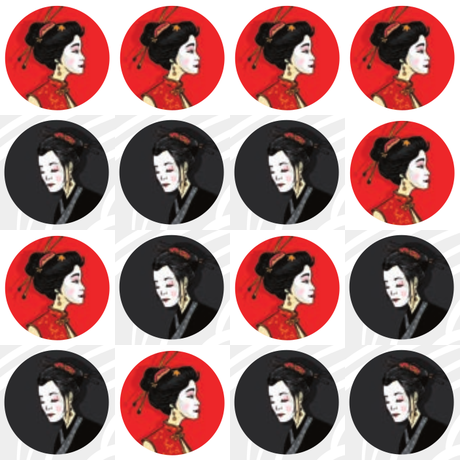

In [13]:
i = 100 # get a 100-th combination, for example
i_bin = bin_interpretation(win_combinations[i], lead_zero_count=16)
tiles = np.array([int(j) for j in i_bin]).reshape([4,4])+16 # 16 is player image bias
draw_tiles(tiles, draw_numbers = False, hi_res = False)
display_image("images/tiles.png")

# Выбор хода

Итак, для любого хода нам потребуется хранить:  
- Маску: 16 бит  
- Ссылки на смещения побед: 12 бит  
Всего 27 бит

In [14]:
#MAX_GRID_DIM_X: 2147483647
bit_27 = int(''.join(['1' for i in range(16+12)]),2)
print('27 бит в десятичном представлении:', bit_27)

27 бит в десятичном представлении: 268435455


In [15]:
grid_size = np.ceil(bit_27/1024).astype(int)
print('размер сетки:', grid_size)

размер сетки: 262144


1. В это ядро передается:
- Игрок, победа которого нас интересует: 0 или 1  
- Текущий ход: от 0 до 15  
- Расположение тайлов игры и фишек игроков: 16 значений от 0 до 17. 16 и 17 значения - фишки игроков  
- Входной вектор смещений побед: 2145 (константа)  
- Выходной вектор: Пакет победных комбинаций маски  
  
2. Из пакета комбинаций маски выбирается случайная и предлагается игроку  
3. Наш игрок Делает ход  
4. Противник делает ход  
5. Переход к п.1

In [19]:
ker = SourceModule("""
__device__ bool win_combination(int i)
{
    int win[17]={
    61440, // row 0
    3840,  // row 1
    240,   // row 2
    15,    // row 3
    34952, // col 0
    17476, // col 1
    8738,  // col 2
    4369,  // col 3
    52224, // quad 0
    26112, // quad 1
    13056, // quad 2
    3264,  // quad 3
    1632,  // quad 4
    816,   // quad 5
    204,   // quad 6
    102,   // quad 7
    51     // quad 8
    };
    for (int a=0;a<17;a++) if ((i&win[a])==win[a]) return(true);    
    return(false);
}

__device__ int ones_counter(int i)
{    
    //for (int a=0;a<16;a++) if ((i&win[a])==win[a]) return(true);    
    //return(false);
    return(0);
}

__global__ void turn(int player, int turn_id, int *init_tiles, int *win_bias, float *out_vec)
{
    // Нулевые ячейки
    //unsigned int zeros[16] = {32767,49151,57343,61439,63487,64511,65023,65279,65407,65471,65503,65519,65527,65531,65533,65534};
    
    // Связи тайлов
    /*unsigned char relations[16][6] = {
    { 1,  2,  3,  4,  8, 12}, 
    { 0,  2,  3,  5,  9, 13}, 
    { 0,  1,  3,  6, 10, 14}, 
    { 0,  1,  2,  7, 11, 15}, 
    { 0,  5,  6,  7,  8, 12}, 
    { 1,  4,  6,  7,  9, 13}, 
    { 2,  4,  5,  7, 10, 14}, 
    { 3,  4,  5,  6, 11, 15}, 
    { 0,  4,  9, 10, 11, 12}, 
    { 1,  5,  8, 10, 11, 13}, 
    { 2,  6,  8,  9, 11, 14}, 
    { 3,  7,  8,  9, 10, 15}, 
    { 0,  4,  8, 13, 14, 15}, 
    { 1,  5,  9, 12, 14, 15}, 
    { 2,  6, 10, 12, 13, 15}, 
    { 3,  7, 11, 12, 13, 14}
    };*/
    
    // Количество фишек нулевого игрока на каждом ходу игры
    unsigned char turn_player_count[16] = {1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8};    
    
    // Идентификатор блока-потока
    unsigned int i = threadIdx.x + blockIdx.x * blockDim.x;
    
    //Распаковка идентификаторов игры
    unsigned char tail_count = 15-turn_id;
    unsigned int comb = i>>16; // bias_12: >100001100001< mask_16: [1111111111111111]
    unsigned int mask = i&65535; // bias_12: [100001100001] mask_16: >1111111111111111<
    
    if (comb<2145) //2145 - this game constant of win combinations count
    {
        comb = win_bias[comb]; //Текущая комбинация, безусловно одна из победных        
        
        // Убедимся, что число единиц и нулей в комбинации соответствует ходу
        int ones = 0;
        for(int a=0;a<16;a++) if ((((int)round(pow(2,a)))&comb)>0) ones++;
        
        // Убедимся, что число тайлов в маске соответствует ходу
        unsigned int tile_ones = 0;
        for(int a=0;a<16;a++) if ((((int)round(pow(2,a)))&comb)>0) tile_ones++;
        
        if (tile_ones==tail_count)
        {
            // Погасим фишки игрока тайлами маски
            comb = comb&mask;
            
            // Проверим, победна ли комбинация выбранного игрока среди возможных
            unsigned int win_tester;
            if (player) win_tester = comb;
            else win_tester = ~comb;
            if (ones==turn_player_count[turn_id] && win_combination(win_tester) && !win_combination(~win_tester)) out_vec[i] = 1;

            /*
            //Количество возможных комбинаций 
            //unsigned int max_grid_dim = 2097151*1024; //2147482624
            //unsigned_int max_gpu_comb = (2097151*1024)>>16; //32767
            unsigned int turn_comb = 256*256*(16^tail_count);

            //Проверим, соответствует ли количество тайлов маски количеству текущего хода
            //if (tail_count) TODO
            int ones = 0;
            for(int a=0;a<16;a++) if ((((int)round(pow(2,a)))&comb)>0) ones++;

            //Обнуление фишек игрока
            unsigned char c,col,cell[16];
            // Идентификатор ячейки
            for (c=0;c<tail_count;c++) cell[c] = i>>12;
            //>>(4*c)&15;

            // Убедимся, что число единиц и нулей в комбинации соответствует ходу
            for(a=0;a<16;a++) if ((((int)round(pow(2,a)))&comb)>0) ones++;

            // Проверим, победна ли комбинация выбранного игрока среди возможных
            unsigned int win_tester;
            if (player) win_tester = comb;
            else win_tester = ~comb;
            if (ones==turn_player_count[turn_id] && win_combination(win_tester) && !win_combination(~win_tester)) out_vec[i] = 1;
            */
        }
    }
}
""")

In [17]:
#MAX_GRID_DIM_X: 2147483647
2097151*1024

2147482624

In [20]:
combinations = np.zeros(1024*262144).astype(np.float32) # 12+16 bytes
turn_id_gpu = np.int32(14)

combinations_gpu_in = gpuarray.to_gpu(win_combinations)
combinations_gpu_out = gpuarray.to_gpu(combinations)


# int player, int turn_id, int *init_tiles, int *win_bias, float *out_vec
combination_check_gpu(    
    np.int32(player),
    turn_id_gpu,
    init_tiles_gpu,
    combinations_gpu_in,
    combinations_gpu_out,
    block=(1024,1,1),
    grid=(262144,1,1)
)

In [22]:
out_combinations = combinations_gpu_out.get()

LogicError: cuMemcpyDtoH failed: an illegal memory access was encountered

In [ ]:
win_combinations = np.where(out_combinations == 1)[0]
print('Количество победных комбинаций:', len(win_combinations))